In [60]:
# import model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import model from model.h5
from keras.models import load_model, Model
model = load_model('model.h5')

In [57]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 262, 262, 3)  0          ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d_6[0][0]']       
                                )                                                           

In [61]:
train_df = pd.read_csv("./split-data/train_new.csv")
traingen=ImageDataGenerator(rescale= 1./255)
train_generator=traingen.flow_from_dataframe(
    dataframe=train_df,
    directory="./dataset",
    x_col="img_path",
    y_col= "category",
    batch_size=64,
    shuffle= True,
    target_size = (256,256),
    class_mode="categorical",
    workers=4
)


Found 10422 validated image filenames belonging to 46 classes.


In [62]:
# remove the last layer
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('dense_14').output)

# save all the features for the test data
features = feature_extractor.predict(train_generator)

2024-12-08 03:35:57.138209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


163/163 [==============================] - 512s 3s/step


In [63]:
# test using the first element of train_generator
import random

# Initialize arrays for storing features, inputs, and labels
features_list = []
inputs_list = []
labels_list = []

total_batches = len(train_generator)
print(total_batches)

batch_index = 0

for batch_x, batch_y in train_generator:
    batch_index += 1
    print("Processing batch:", batch_index)
    batch_features = model.predict(batch_x)
    features_list.append(batch_features)
    inputs_list.append(batch_x)
    labels_list.append(batch_y)
    if batch_index >= total_batches:
        break

image_paths = train_df["img_path"].values

# Convert lists to NumPy arrays
features = np.concatenate(features_list, axis=0)
inputs = np.concatenate(inputs_list, axis=0)
labels = np.concatenate(labels_list, axis=0)

# Save features, inputs, and labels to a file
data_to_save = {
    'features': features,
    'inputs': inputs,
    'labels': labels,
    'paths': image_paths
}



163
Processing batch: 1
2/2 [==============================] - 4s 1s/step
Processing batch: 2
2/2 [==============================] - 3s 1s/step
Processing batch: 3
2/2 [==============================] - 2s 1s/step
Processing batch: 4
2/2 [==============================] - 3s 1s/step
Processing batch: 5
2/2 [==============================] - 3s 1s/step
Processing batch: 6
2/2 [==============================] - 3s 1s/step
Processing batch: 7
2/2 [==============================] - 3s 1s/step
Processing batch: 8
2/2 [==============================] - 3s 1s/step
Processing batch: 9
2/2 [==============================] - 3s 1s/step
Processing batch: 10
2/2 [==============================] - 3s 1s/step
Processing batch: 11
2/2 [==============================] - 3s 1s/step
Processing batch: 12
2/2 [==============================] - 3s 1s/step
Processing batch: 13
2/2 [==============================] - 3s 1s/step
Processing batch: 14
2/2 [==============================] - 3s 1s/step
Processing 

In [64]:
import pickle

with open('clothing_features_with_paths.pkl', 'wb') as f:
	pickle.dump(data_to_save, f, protocol=pickle.HIGHEST_PROTOCOL)

np.set_printoptions(threshold=1000) 
print("Features shape:", features.shape)
print("First feature vector:", features[0])

Features shape: (10422, 46)
First feature vector: [1.7627229e-03 1.6974088e-02 4.6280760e-01 2.3077438e-03 3.8696349e-02
 1.3400855e-02 1.3104379e-05 1.0660468e-02 1.7443884e-04 1.9723361e-03
 9.7907102e-03 7.4998534e-04 8.4277778e-04 1.3244847e-02 7.2179162e-03
 6.8527216e-04 1.9459735e-03 9.6099563e-03 1.6107671e-02 5.8117430e-03
 2.1793756e-04 8.1099941e-05 1.9935664e-02 5.0202059e-04 2.8891838e-04
 6.3632890e-03 6.8942970e-03 3.5943087e-02 1.3204291e-04 1.7896734e-04
 3.4601334e-04 5.1397590e-05 2.4702685e-02 4.6220571e-02 2.0473748e-02
 1.0635578e-04 2.4289852e-03 2.0201297e-03 1.2011250e-02 4.6470293e-04
 1.7565591e-03 8.4000984e-03 3.0089224e-02 1.6277191e-01 8.0132054e-04
 2.0411150e-03]


In [65]:
import numpy as np

features = features.astype('float32')

np.save('faiss_features.npy', features)
np.save('faiss_inputs.npy', inputs)
np.save('faiss_labels.npy', labels)

print("Features and metadata saved for Faiss.")


Features and metadata saved for Faiss.


In [66]:
import faiss

# Load saved features
with open('clothing_features_with_paths.pkl', 'rb') as f:
    saved_data = pickle.load(f)
features = saved_data['features']
image_paths = saved_data['paths']

# Get dimensionality of features
d = features.shape[1]  # Feature vector dimension

# Create Faiss index (using L2 distance for exact search)
index = faiss.IndexFlatL2(d)
# L2 normalization
norms = np.linalg.norm(features, axis=1, keepdims=True)
normalized_features = features / norms
index.add(normalized_features)  # Add feature vectors to the index

print(f"Number of vectors in the index: {index.ntotal}")

Number of vectors in the index: 10422


In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
from matplotlib import pyplot as plt


Shape of labels: (1913, 46)
Shape of features: (1913, 512)
Unique labels: [0. 1.]
Shape of labels after conversion: (1913, 46)


ValueError: 'c' argument has 87998 elements, which is inconsistent with 'x' and 'y' with size 1913.

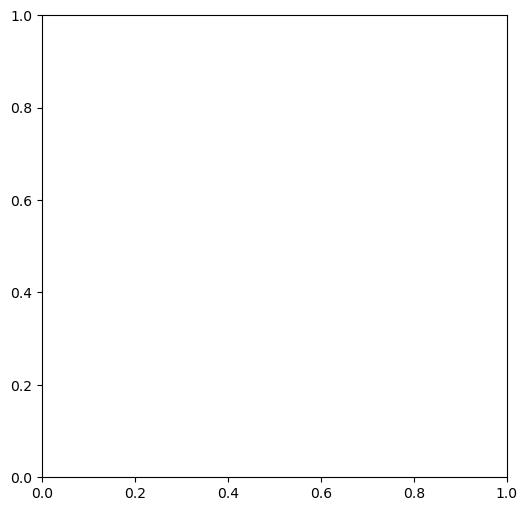

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("Shape of labels:", labels.shape)  # Should be (2560,)
print("Shape of features:", features.shape)  # Should be (2560, 1024)
print("Unique labels:", np.unique(labels))


# Check the new shape of labels
print("Shape of labels after conversion:", labels.shape)

# Reduce embedding dimensions to 2D for visualization
tsne = TSNE(n_components=2, random_state=50)
reduced_embeddings = tsne.fit_transform(features)

# Plot the embeddings with labels
plt.figure(figsize=(6, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='tab10', s=5)
plt.colorbar()
plt.title("2D Visualization of Embedding Space")
plt.show()

2024-12-08 04:01:05.882464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 1s 836ms/step
Extracted feature vector: [[0.         0.26483536 0.         0.36346406 0.         0.31094527
  0.         0.506656   0.         0.         0.4528857  0.45353276
  0.         0.19537574 0.         0.         0.11473605 0.6103332
  1.4487976  0.3096177  0.22631297 0.46388555 1.0070473  0.50766367
  0.         0.         0.35427254 0.29734054 0.21230315 0.8997387
  0.9815097  0.11780949 0.18744785 1.0357313  0.5681868  0.
  0.9341347  0.         0.75522953 0.         0.4356528  0.05761747
  0.34520432 0.49343398 0.         0.47484583 0.48580715 0.02687114
  0.         0.8362898  0.         0.47169197 0.27964798 0.8718658
  0.         0.10788658 0.         0.0199463  0.         0.
  0.27053452 0.6993827  0.         0.         0.32087463 0.
  0.         0.3634174  0.1279815  0.         0.13854335 0.2954438
  0.         0.14057167 0.         0.5761107  0.         0.
  0.7471146  0.6233495  0.         0.         0.09494048 0.
  0.11688813 

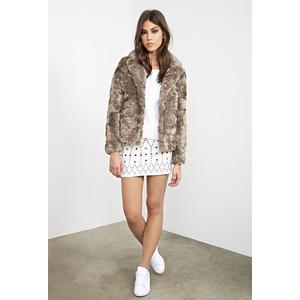

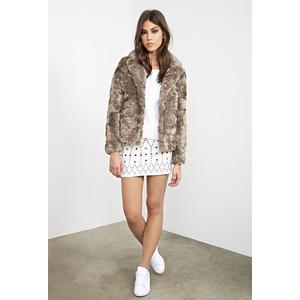

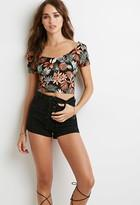

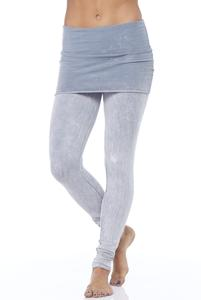

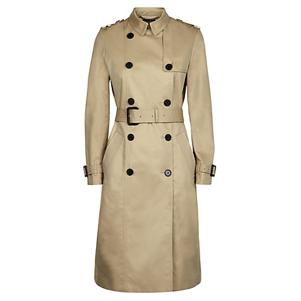

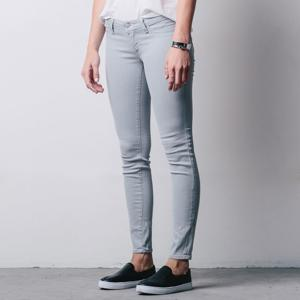

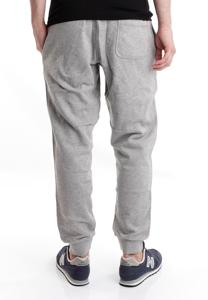

In [80]:
from IPython.display import display, Image
import random


# Load and preprocess the new input image
new_input_path = "dataset/img/Belted_Polka_Dot_Dress/img_00000001.jpg"    # Replace with your image path
img = load_img(new_input_path, target_size=(256, 256))  # Resize to match `target_size`
img_array = img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, H, W, C)

random_index = random.randint(0, 3840) # should be number of image paths
random_image_path = image_paths[random_index]
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('dense_14').output)

# Create an ImageDataGenerator for preprocessing
inputgen = ImageDataGenerator(rescale=1./255)

# Preprocess the new input
new_input_generator = inputgen.flow(img_array, batch_size=1)

new_input_features = feature_extractor.predict(new_input_generator)
random_feature = features[random_index].reshape(1, -1)

# normalize the feature vector
norms = np.linalg.norm(random_feature, axis=1, keepdims=True)
normalized_feature = random_feature / norms

print("Extracted feature vector:", new_input_features)
print(labels[random_index])



k = 6  # Number of neighbors to retrieve
print("Shape of features[random_index]:", normalized_feature)
print(image_paths[random_index])
distances, indices = index.search(normalized_feature, k)

print("Distances:", distances)
print("Indices:", indices)

similar_image_paths = [image_paths[idx] for idx in indices[0]]
original_path = ("./dataset/" + random_image_path)
print(similar_image_paths)

# Display the original and similar images
def display_images(original_path, similar_image_paths):
    display(Image(filename = original_path))
    
    for path in similar_image_paths:
        display(Image(filename="./dataset/" + path))

display_images(original_path, similar_image_paths)